In [1]:
import sys
sys.path.append('..')

In [2]:
import io
import math
from pathlib import Path

import numpy as np
import cv2 as cv
import pytesseract
from PIL import Image as PImage, ImageDraw, ImageOps

In [3]:
DATA_DIR = Path('..') / 'data'
MODEL_DIR = DATA_DIR / 'model'
LABEL_DIR = DATA_DIR / 'labels' / 'typewritten'

MODEL = MODEL_DIR / 'frozen_east_text_detection.pb'

In [4]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int")

In [5]:
IMAGES = sorted(LABEL_DIR.glob('*.jpg'))

In [6]:
IDX = 46
print(IMAGES[IDX])

../data/labels/typewritten/10667427.jpg


In [7]:
MIN_CONF = 0.5

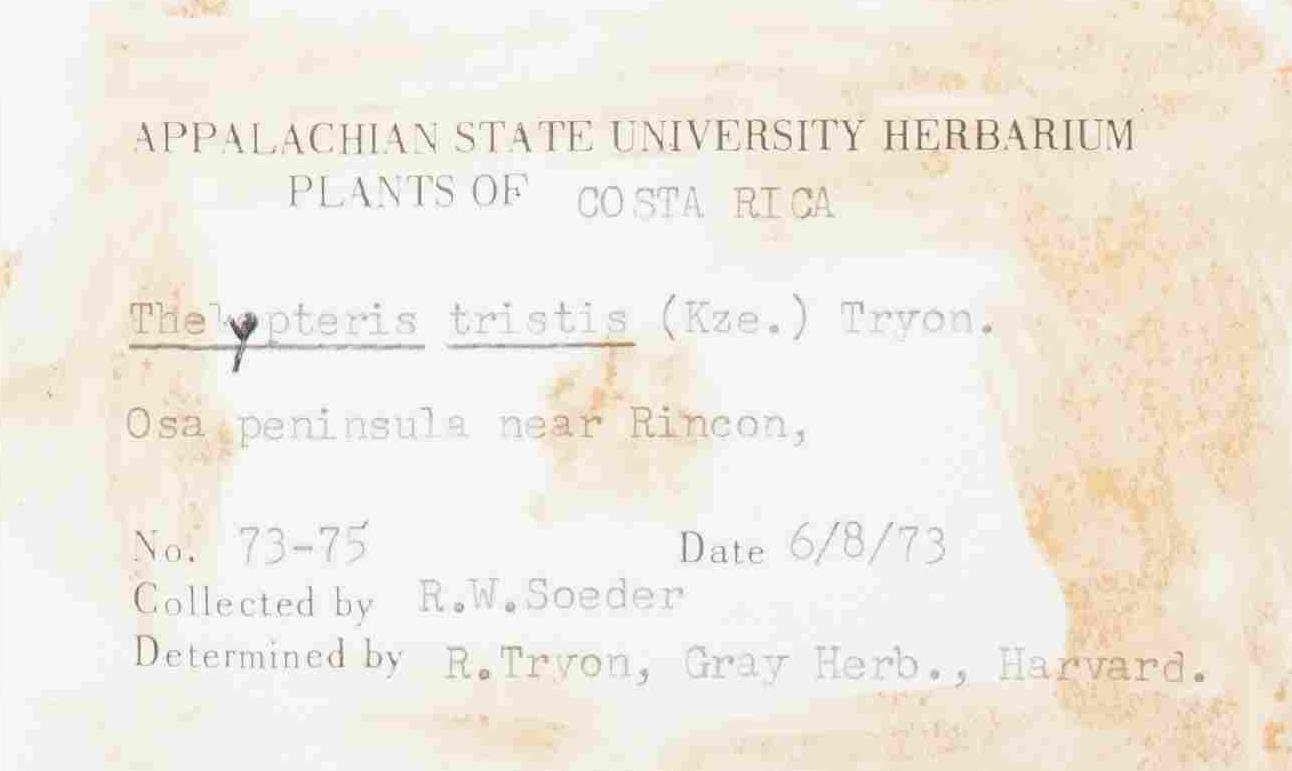

In [8]:
image = cv.imread(str(IMAGES[IDX]))
orig = image.copy()

temp = cv.cvtColor(image, cv.COLOR_BGR2RGB)
display(PImage.fromarray(temp))

In [9]:
H, W = image.shape[:2]
print(H, W)

771 1292


In [10]:
new_W = math.ceil(W / 32) * 32
new_H = math.ceil(H / 32) * 32
print(new_H, new_W)

800 1312


In [11]:
pad_left = (new_W - W) // 2
pad_right = new_W - W - pad_left

pad_top = (new_H - H) // 2
pad_bottom = new_H - H - pad_top

print(pad_top, pad_bottom, pad_left, pad_right)

14 15 10 10


In [12]:
image = cv.copyMakeBorder(
    image,
    pad_top, pad_bottom, pad_left, pad_right,
    cv.BORDER_CONSTANT,
    value=(0, 0, 0))

(H, W) = image.shape[:2]

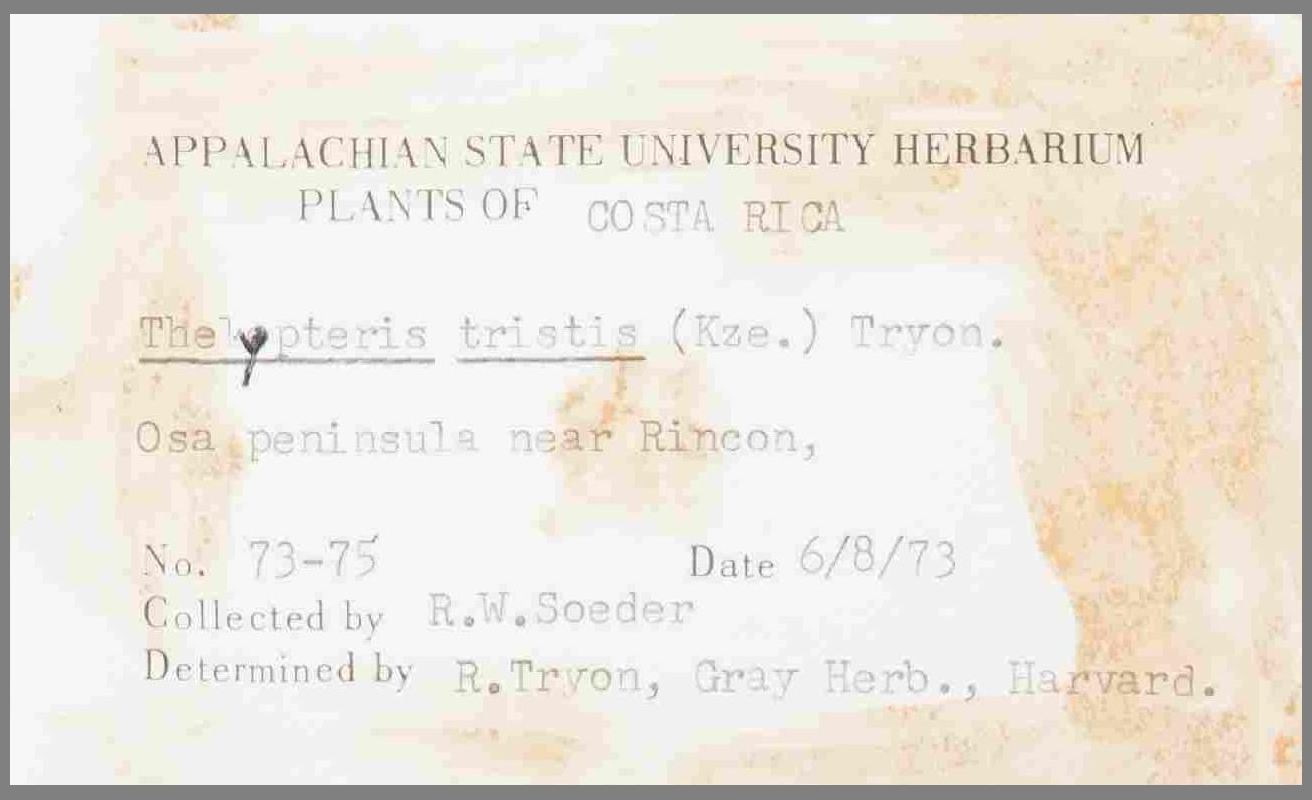

In [13]:
# image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
temp = cv.cvtColor(image, cv.COLOR_BGR2RGB)
display(PImage.fromarray(temp))

In [14]:
net = cv.dnn.readNet(str(MODEL))

In [15]:
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [16]:
blob = cv.dnn.blobFromImage(
    image, 1.0, (W, H),
    (123.68, 116.78, 103.94),
    swapRB=True, crop=False)

In [17]:
net.setInput(blob)
scores, geometry = net.forward(layerNames)

In [18]:
scores

array([[[[3.29359068e-07, 3.23524176e-07, 2.35847466e-07, ...,
          1.65334740e-07, 1.69274429e-07, 2.18746618e-06],
         [2.18917558e-06, 2.58340947e-07, 7.23314884e-07, ...,
          1.59578587e-06, 3.17183776e-07, 2.27066903e-06],
         [2.17072056e-06, 4.34183818e-07, 1.62775655e-06, ...,
          2.05205197e-06, 1.62574295e-07, 3.41795771e-06],
         ...,
         [9.54884626e-07, 8.91730167e-07, 2.79303845e-06, ...,
          3.93767687e-06, 4.70560565e-07, 6.71283829e-07],
         [1.78199912e-06, 3.86253589e-07, 5.62380535e-07, ...,
          2.16658850e-06, 1.84280680e-06, 2.99251678e-06],
         [5.90671220e-07, 1.96927115e-08, 4.74554529e-09, ...,
          6.34915409e-08, 1.00195905e-07, 2.82214785e-08]]]],
      dtype=float32)

In [19]:
rows, cols = scores.shape[2:4]

rects = []
confidences = []

# rows, cols

In [20]:
for y in range(rows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(cols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < MIN_CONF:
            continue
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [22]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
#     startX = int(startX * rW)
#     startY = int(startY * rH)
#     endX = int(endX * rW)
#     endY = int(endY * rH)
    
    cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

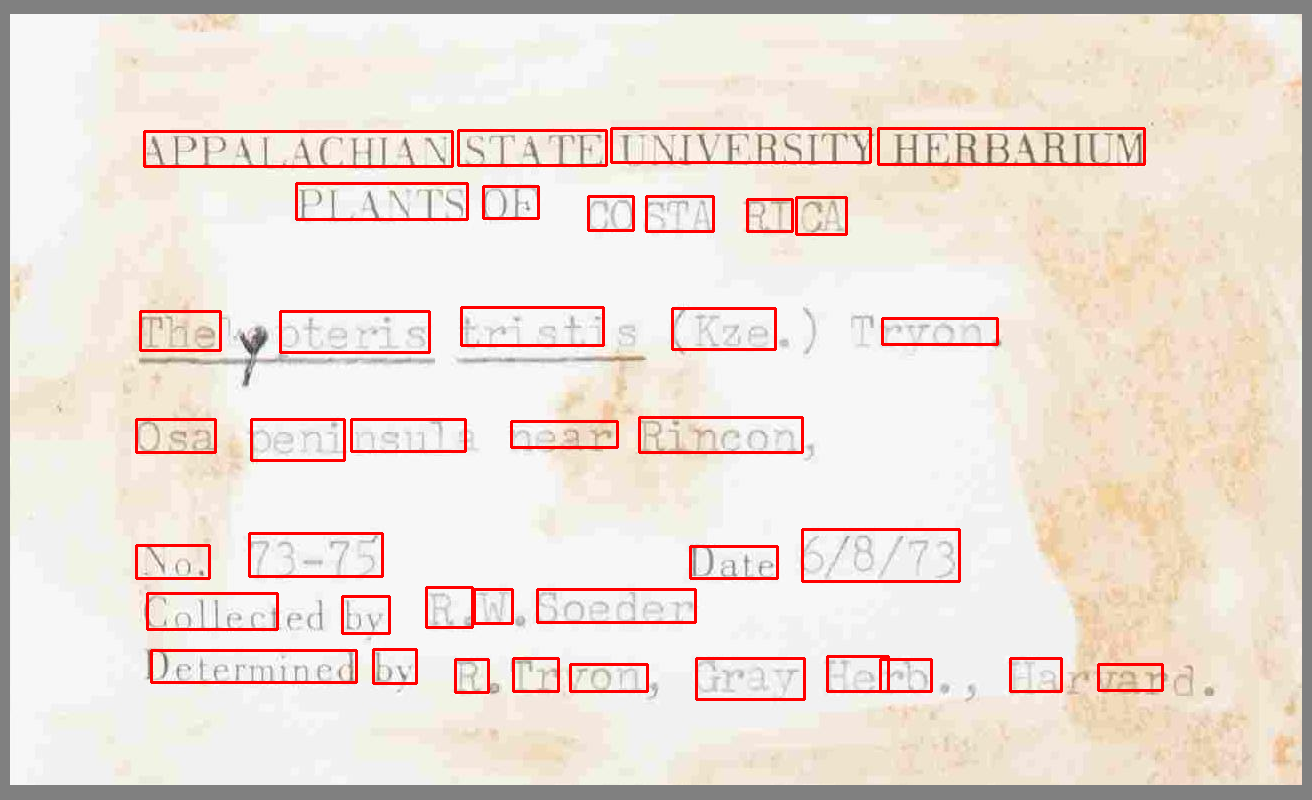

In [23]:
temp = cv.cvtColor(image, cv.COLOR_BGR2RGB)
display(PImage.fromarray(temp))